# Exploring  SHAP-IQ visualizations
In this tutorial, we’ll explore a range of SHAP-IQ visualizations that provide insights into how a machine learning model arrives at its predictions. These visuals help break down complex model behavior into interpretable components—revealing both the individual and interactive contributions of features to a specific prediction.



## Installing the dependencies

In [ ]:
!pip install shapiq overrides scikit-learn pandas numpy seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.3/284.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 44.1 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm.asyncio import tqdm

import shapiq

print(f"shapiq version: {shapiq.__version__}")

shapiq version: 1.3.1


## Importing the dataset
In this tutorial, we’ll use the MPG (Miles Per Gallon) dataset, which we’ll load directly from the Seaborn library. This dataset contains information about various car models, including features like horsepower, weight, and origin.

In [ ]:
import seaborn as sns
df = sns.load_dataset("mpg")
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,usa,ford mustang gl
394,44.0,4,97.0,52.0,2130,24.6,82,europe,vw pickup
395,32.0,4,135.0,84.0,2295,11.6,82,usa,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,usa,ford ranger


## Processing the dataset
We use Label Encoding to convert the categorical column(s) into numeric format, making them suitable for model training.



In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Drop rows with missing values
df = df.dropna()

# Encoding the origin column
le = LabelEncoder()
df.loc[:, "origin"] = le.fit_transform(df["origin"])
df['origin'].unique()

array([2, 1, 0], dtype=object)

In [ ]:
for i, label in enumerate(le.classes_):
    print(f"{label} → {i}")

europe → 0
japan → 1
usa → 2


## Splitting the data into training & test subsets

In [ ]:
# Select features and target
X = df.drop(columns=["mpg", "name"])
y = df["mpg"]

feature_names = X.columns.tolist()
x_data, y_data = X.values, y.values

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

## Model Training
We train a Random Forest Regressor with a maximum depth of 10 and 10 decision trees (n_estimators=10). A fixed random_state ensures reproducibility.

In [ ]:
# Train model
model = RandomForestRegressor(random_state=42, max_depth=10, n_estimators=10)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)

## Model Evaluation

In [ ]:
# Evaluate
mse = mean_squared_error(y_test, model.predict(x_test))
r2 = r2_score(y_test, model.predict(x_test))
print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")

Mean Squared Error: 7.71
R2 Score: 0.85


## Explaining a Local Instance
We choose a specific test instance (with instance_id = 7) to explore how the model arrived at its prediction. We'll print the true value, predicted value, and the feature values for this instance.

In [ ]:
# select a local instance to be explained
instance_id = 7
x_explain = x_test[instance_id]
y_true = y_test[instance_id]
y_pred = model.predict(x_explain.reshape(1, -1))[0]
print(f"Instance {instance_id}, True Value: {y_true}, Predicted Value: {y_pred}")
for i, feature in enumerate(feature_names):
    print(f"{feature}: {x_explain[i]}")

Instance 7, True Value: 26.0, Predicted Value: 27.905
cylinders: 4
displacement: 97.0
horsepower: 75.0
weight: 2265
acceleration: 18.2
model_year: 77
origin: 1


## Generating Explanations for Multiple Interaction Orders
We generate Shapley-based explanations for different interaction orders using the shapiq package. Specifically, we compute:

* **Order 1 (Standard Shapley Values):** Individual feature contributions

* **Order 2 (Pairwise Interactions):** Combined effects of feature pairs

* **Order N (Full Interaction):** All interactions up to the total number of features

In [ ]:
# create explanations for different orders
feature_names = list(X.columns)  # get the feature names
n_features = len(feature_names)

si_order: dict[int, shapiq.InteractionValues] = {}
for order in tqdm([1, 2, n_features]):
    index = "k-SII" if order > 1 else "SV"  # will also be set automatically by the explainer
    explainer = shapiq.TreeExplainer(model=model, max_order=order, index=index)
    si_order[order] = explainer.explain(x=x_explain)
si_order

100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


{1: InteractionValues(
     index=SV, max_order=1, min_order=0, estimated=False, estimation_budget=None,
     n_players=7, baseline_value=23.513961661341856
 ),
 2: InteractionValues(
     index=k-SII, max_order=2, min_order=0, estimated=False, estimation_budget=None,
     n_players=7, baseline_value=23.513961661341856
 ),
 7: InteractionValues(
     index=k-SII, max_order=7, min_order=0, estimated=False, estimation_budget=None,
     n_players=7, baseline_value=23.513961661341856
 )}

## Force Chart
The force plot is a powerful visualization tool that helps us understand how a machine learning model arrived at a specific prediction. It displays the baseline prediction (i.e., the expected value of the model before seeing any features), and then shows how each feature "pushes" the prediction higher or lower.

In this plot:

* Red bars represent features or interactions that increase the prediction.

* Blue bars represent those that decrease it.

* The length of each bar corresponds to the magnitude of its effect.

When using Shapley interaction values, the force plot can visualize not just individual contributions but also interactions between features. This makes it especially insightful when interpreting complex models, as it visually decomposes how combinations of features work together to influence the outcome.


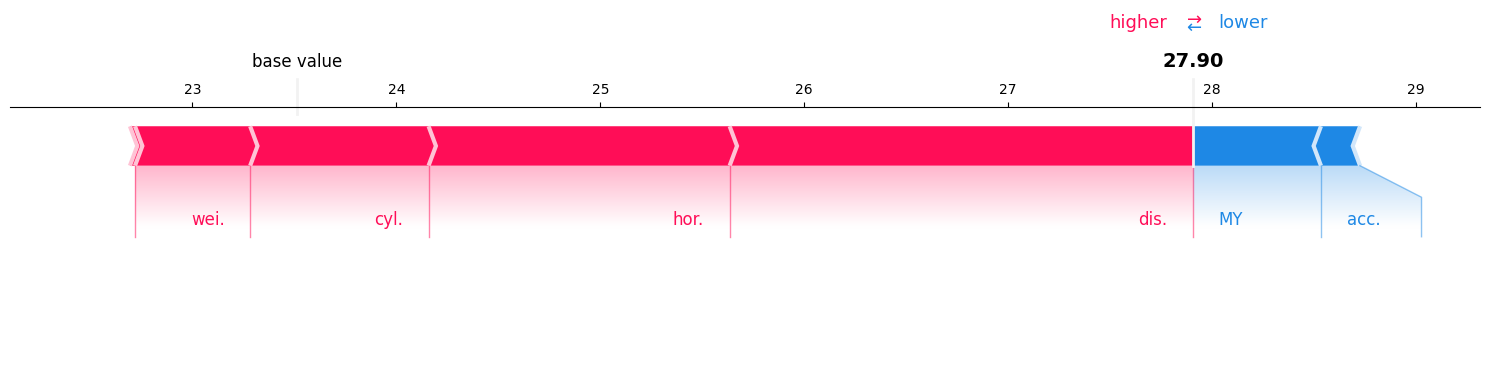

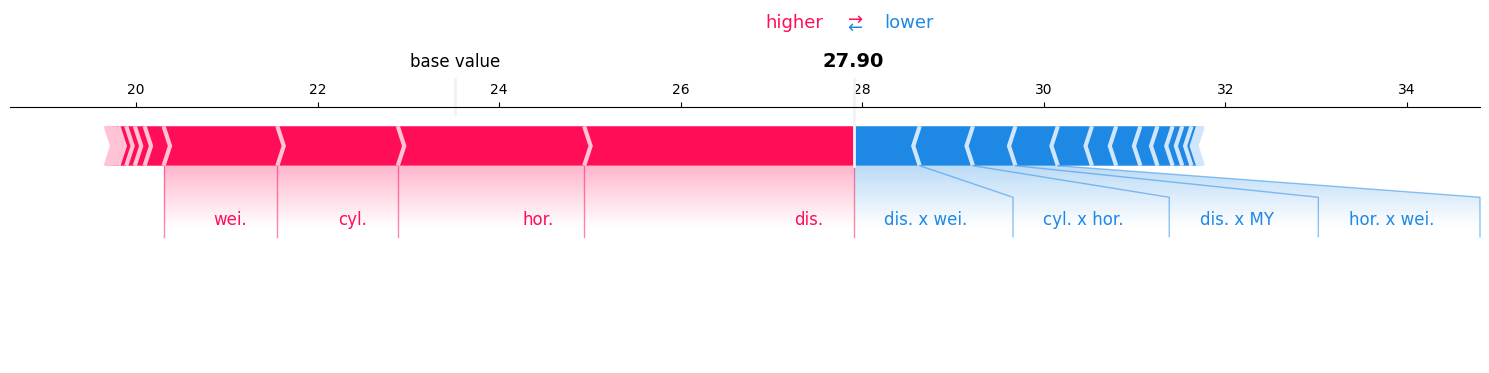

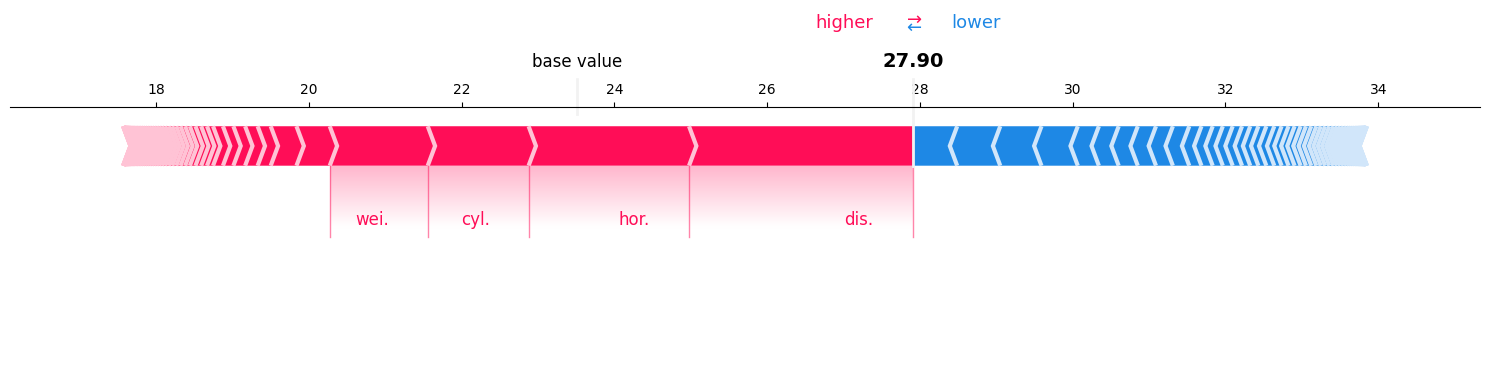

In [ ]:
sv = si_order[1]  # get the SV
si = si_order[2]  # get the 2-SII
mi = si_order[n_features]  # get the Moebius transform

sv.plot_force(feature_names=feature_names, show=True)
si.plot_force(feature_names=feature_names, show=True)
mi.plot_force(feature_names=feature_names, show=True)

From the first plot, we can see that the base value is 23.5. Features like Weight, Cylinders, Horsepower, and Displacement have a positive influence on the prediction, pushing it above the baseline. On the other hand, Model Year and Acceleration have a negative impact, pulling the prediction downward.

## Waterfall Chart
Similar to the force plot, the waterfall plot is another popular way to visualize Shapley values, originally introduced with the shap library. It shows how different features push the prediction higher or lower compared to the baseline. One key advantage of the waterfall plot is that it automatically groups features with very small impacts into an “other” category, making the chart cleaner and easier to understand.

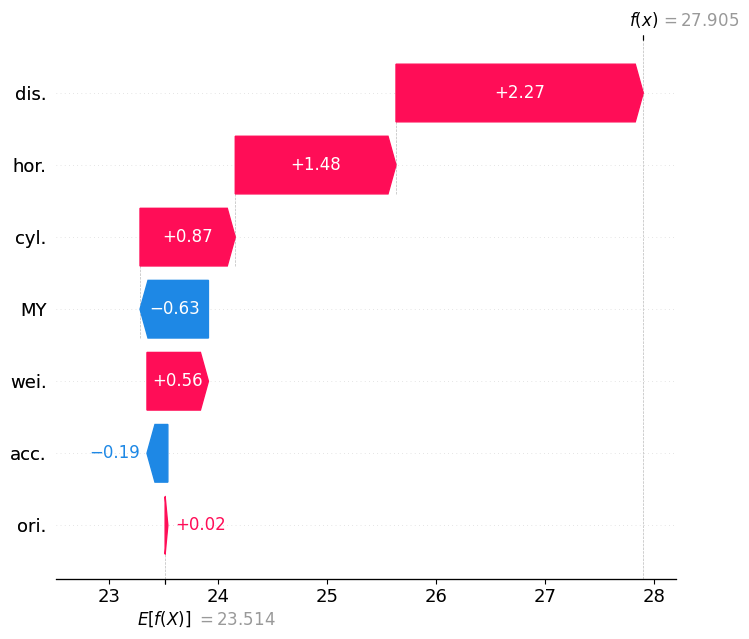

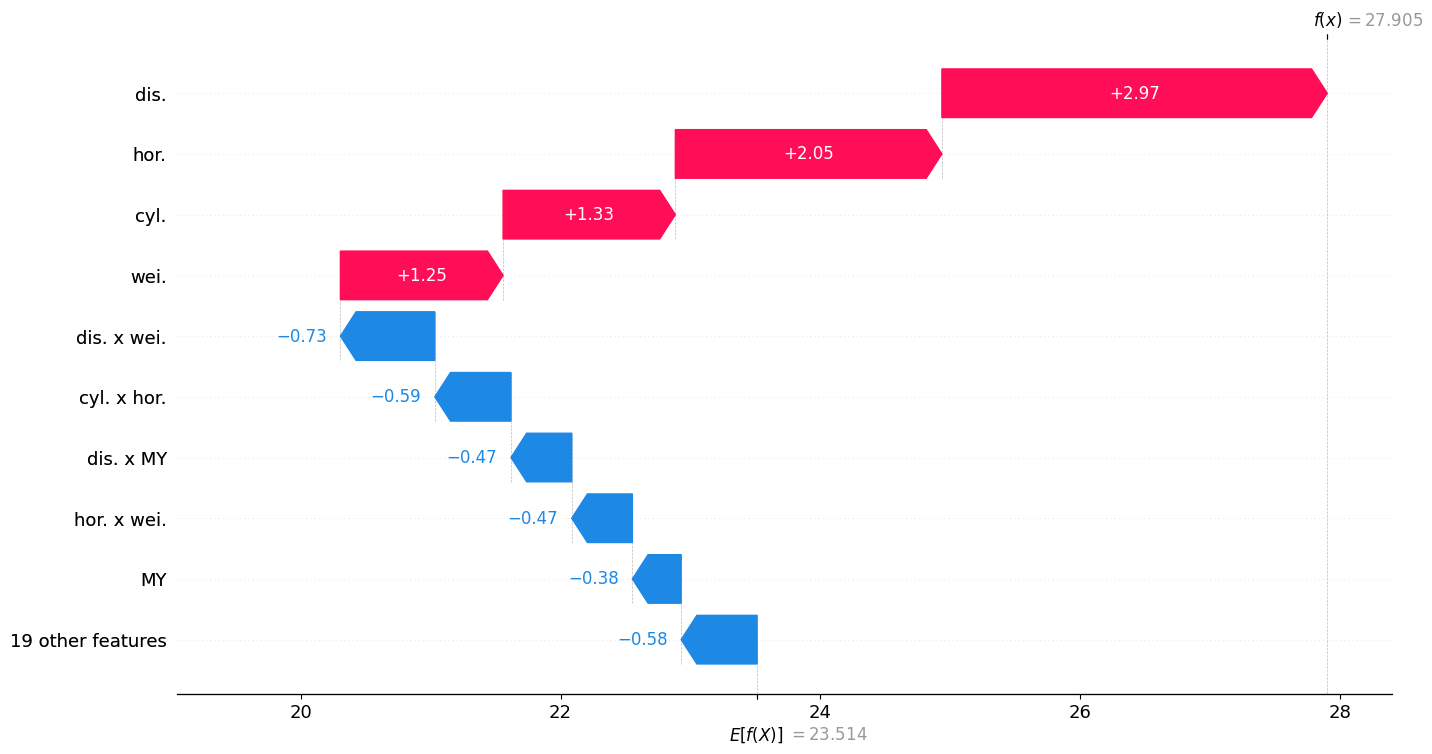

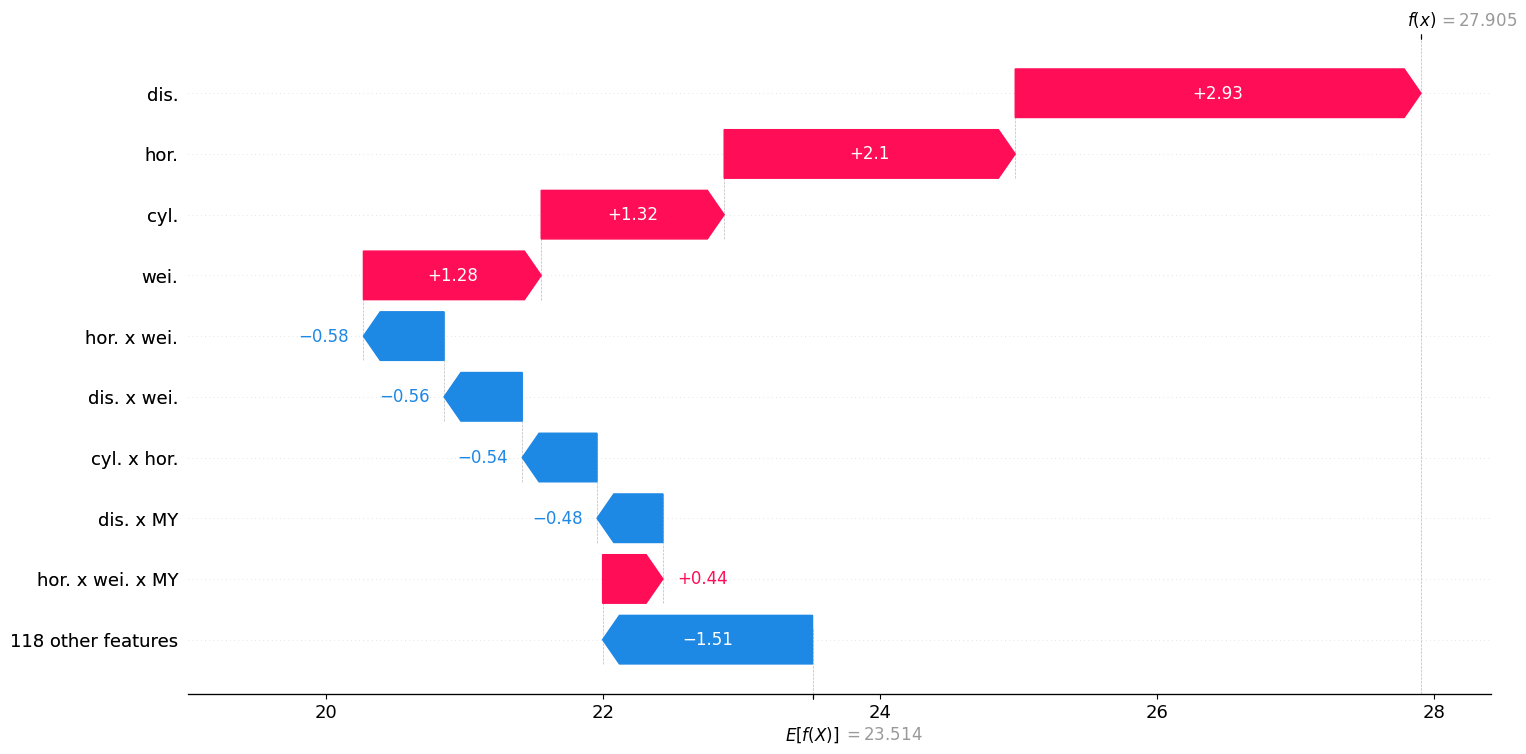

In [ ]:
sv.plot_waterfall(feature_names=feature_names, show=True)
si.plot_waterfall(feature_names=feature_names, show=True)
mi.plot_waterfall(feature_names=feature_names, show=True)

## Network Plot
The network plot shows how features interact with each other using first- and second-order Shapley interactions. Node size reflects individual feature impact, while edge width and color show interaction strength and direction. It's especially helpful when dealing with many features, revealing complex interactions that simpler plots might miss

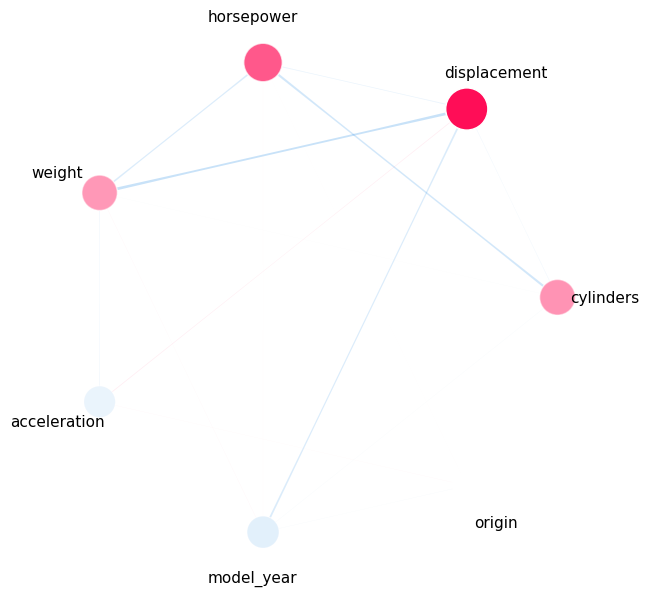

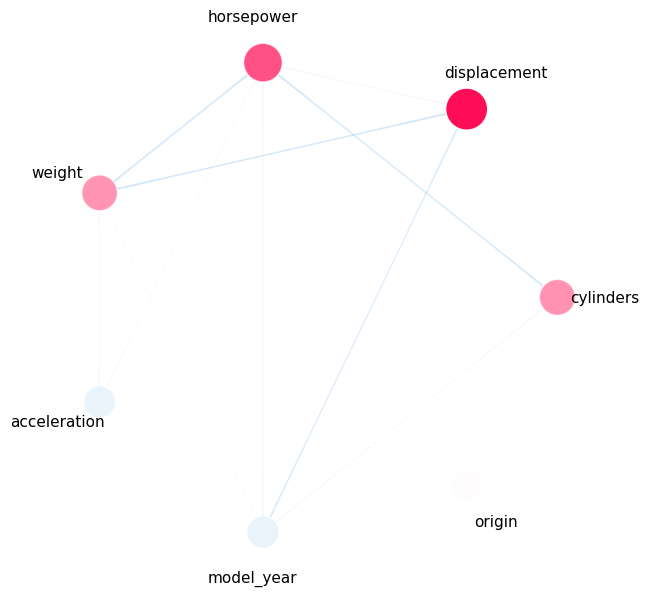

In [ ]:
si.plot_network(feature_names=feature_names, show=True)
mi.plot_network(feature_names=feature_names, show=True)

## SI Graph Plot
The SI graph plot extends the network plot by visualizing all higher-order interactions as hyper-edges connecting multiple features. Node size shows individual feature impact, while edge width, color, and transparency reflect the strength and direction of interactions. It provides a comprehensive view of how features jointly influence the model's prediction.

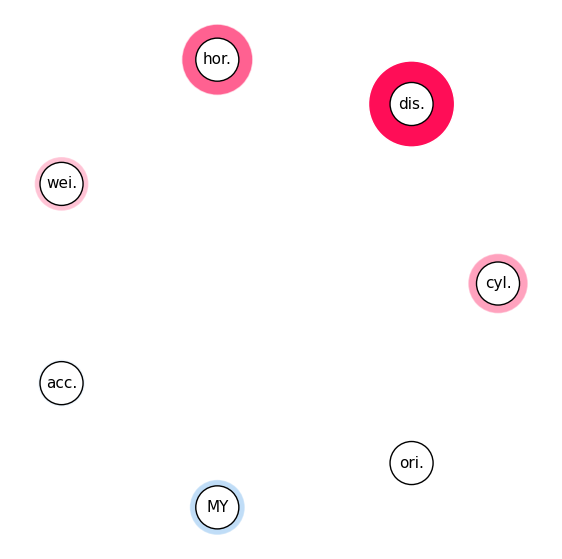

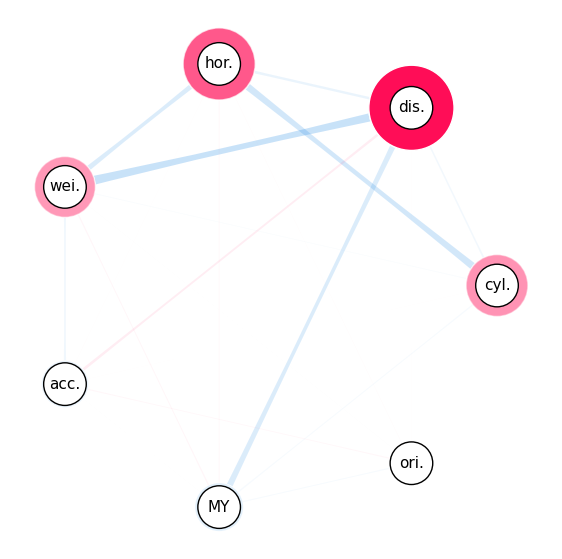

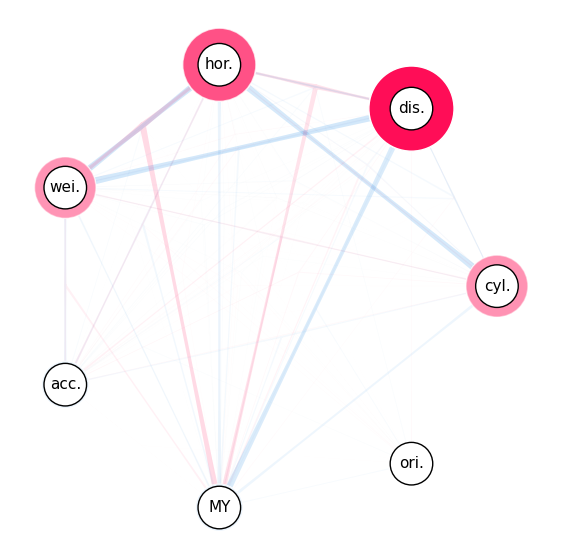

In [ ]:
# we abbreviate the feature names since, they are plotted inside the nodes
abbrev_feature_names = shapiq.plot.utils.abbreviate_feature_names(feature_names)
sv.plot_si_graph(
    feature_names=abbrev_feature_names,
    show=True,
    size_factor=2.5,
    node_size_scaling=1.5,
    plot_original_nodes=True,
)
si.plot_si_graph(
    feature_names=abbrev_feature_names,
    show=True,
    size_factor=2.5,
    node_size_scaling=1.5,
    plot_original_nodes=True,
)
mi.plot_si_graph(
    feature_names=abbrev_feature_names,
    show=True,
    size_factor=2.5,
    node_size_scaling=1.5,
    plot_original_nodes=True,
)

## Bar Plot
The bar plot is tailored for global explanations. While other plots can be used both locally and globally, the bar plot summarizes the overall importance of features (or feature interactions) by showing the mean absolute Shapley (or interaction) values across all instances. In shapiq, it highlights which feature interactions contribute most on average.

In [ ]:
explanations = []
explainer = shapiq.TreeExplainer(model=model, max_order=2, index="k-SII")
for instance_id in tqdm(range(20)):
    x_explain = x_test[instance_id]
    si = explainer.explain(x=x_explain)
    explanations.append(si)

100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


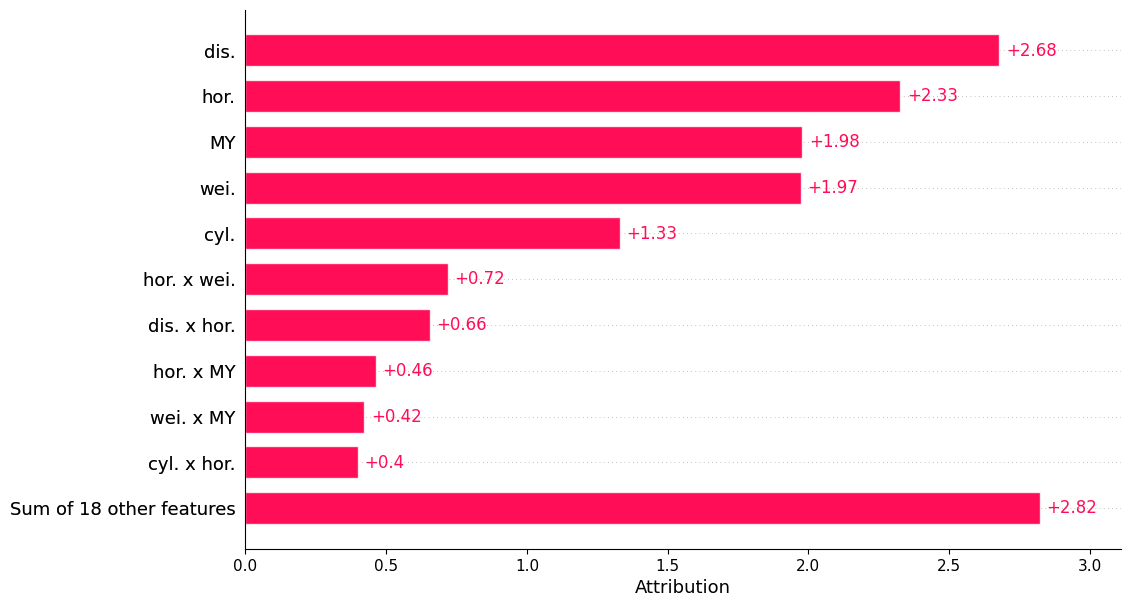

In [ ]:
shapiq.plot.bar_plot(explanations, feature_names=feature_names, show=True)

"Distance" and "Horsepower" are the most influential features overall, meaning they have the strongest individual impact on the model's predictions. This is evident from their high mean absolute Shapley interaction values in the bar plot.

Additionally, when looking at second-order interactions (i.e., how two features interact together), the combinations "Horsepower × Weight" and "Distance × Horsepower" show significant joint influence. Their combined attribution is around 1.4, indicating that these interactions play an important role in shaping the model's predictions beyond what each feature contributes individually. This highlights the presence of non-linear relationships between features in the model.